# generate embeddings using HuggingFaceEmbeddings

In [33]:
import glob
import os

files_paths = glob.glob("/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/*.pdf")

In [25]:
# load pdfs into dict of key file_path, value list of document objects split by page number

from langchain_community.document_loaders import PyPDFLoader
from tqdm import tqdm

def load_pdfs(file_paths):
    """
    file_paths must end with .pdf
    PyPDFLoader auto splits the pdf into pages, each page is 1 Document object

    returns a dict of key: file_path and value: list of document objects
    """
    documents_dict = {}   
    for f in tqdm(file_paths):
        loader = PyPDFLoader(file_path = f)
        documents = loader.load()
        documents_dict[f] = documents
    return documents_dict

In [27]:
documents_dict = load_pdfs(file_paths=files_paths)

  0%|          | 0/22 [00:00<?, ?it/s]/Users/I748920/Library/Python/3.9/lib/python/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4
100%|██████████| 22/22 [00:33<00:00,  1.51s/it]


In [35]:
# print(len(documents_dict) == len(files_paths), len(documents_dict))

# # print all the keys

# from pprint import pprint

# for k in documents_dict.keys():
#     print(k)

In [37]:
# check

print(len(documents_dict['/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap10.pdf']))
d = documents_dict['/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap10.pdf']
print(len(d[0].page_content))

52
1413


In [42]:
# chunk the pdfs

from langchain_text_splitters import RecursiveCharacterTextSplitter

def chunk_list_of_documents(documents):
    """
    input a list of documents as Document objects

    output a list of chunks as Document objects
    """

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 500,
        chunk_overlap = 100, # using 20% is a good start
        length_function=len,
        is_separator_regex=False,
        add_start_index=True
    )

    chunks = text_splitter.split_documents(documents)    
    return chunks

use only chap 16-18

In [44]:
keys = [
    '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap16.pdf',
    '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap17.pdf',
    '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf'
]

In [48]:
all_chunks = []

for key in tqdm(keys):
    documents = documents_dict[key]
    chunks = chunk_list_of_documents(documents=documents)
    all_chunks.extend(chunks)

len(all_chunks)

100%|██████████| 3/3 [00:00<00:00, 129.03it/s]


528

In [52]:
# check 
chunks[0]

Document(metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 0, 'start_index': 0}, page_content='This is page 649\nPrinter: Opaque this\n18\nHigh-Dimensional Problems: p≫N\n18.1 When pis Much Bigger than N\nIn this chapter we discuss prediction problems in which the n umber of\nfeaturespis much larger than the number of observations N, often written\np≫N. Such problems have become of increasing importance, espec ially in\ngenomics and other areas of computational biology. We will s ee that high\nvariance and overﬁtting are a major concern in this setting. As a result,')

In [59]:
# setup embedding model

from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

hf_embedding_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [73]:
# setup vectordb, using HF embedding model

from langchain_core.vectorstores import InMemoryVectorStore

start_time=time.time()
vectorstore_hf = InMemoryVectorStore.from_documents(
    documents=chunks,
    embedding=hf_embedding_model
)

print("time taken: ",round(time.time()-start_time,2),"s")

time taken:  15.72 s


In [86]:
# setup retrieval and test with a query and gt_context

retriever_hf = vectorstore_hf.as_retriever(
    search_type='similarity',
    search_kwargs = {'k':6 }
)

sample_query = "for high-dimensional problems, with regards to p and N, in what \
cases can ridge regression exploit the correlation in the features of the dataset?"
sample_gt_context_start_index = 397
sample_gt_context = [c for c in chunks if c.metadata['start_index']==sample_gt_context_start_index][0]

print(sample_query)
print(sample_gt_context.page_content)

for high-dimensional problems, with regards to p and N, in what cases can ridge regression exploit the correlation in the features of the dataset?
using the optimal ridge parameter in each of the three cases, the median
value of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values
exceeding 2 was equal to 9.8, 1.2 and 0.0.
Ridge regression with λ= 0.001 successfully exploits the correlation in
the features when p<N, but cannot do so when p≫N. In the latter case
there is not enough information in the relatively small numb er of samples
to eﬃciently estimate the high-dimensional covariance mat rix. In that case,


In [91]:
retrieved_docs_hf = retriever_hf.invoke(input=sample_query)

In [93]:
retrieved_docs_hf

[Document(id='0bdfb511-497a-44a7-a808-15f7dc4cb02e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'),
 Document(id='07cf95bb-ef63-4ba4-9514-02161fe5cccb', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 760}, page_content='over the 100 simulation runs. The p= 1000 case is des

In [102]:
retrieved_docs_hf[0].page_content==sample_gt_context.page_content

True

retriever works fine

# setup RAG chain without memory, using Ollama LLM and HuggingFaceEmbeddings

In [108]:
# setup ollama-llm

from langchain_ollama import ChatOllama

llm_model = ChatOllama(
    model='llama3.1',
    temperature=0 # increase temp for more creative answers
)

In [112]:
# test sentence

start_time = time.time()
llm_model.invoke('explain gravity in 1 sentence')
print(f'time taken: {round(time.time()-start_time,2)}s')

time taken: 1.41s


In [133]:
# setup rag prompt

from langchain import hub

rag_prompt_template = hub.pull("rlm/rag-prompt")

In [135]:
rag_prompt_template.input_variables

['context', 'question']

In [137]:
rag_prompt_template.messages

[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]

In [139]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

message_input = {"question": RunnablePassthrough(), "context": retriever_hf}

rag_chain = message_input| rag_prompt_template | llm_model | StrOutputParser()

In [141]:
rag_chain.invoke(input=sample_query)

'Ridge regression can exploit the correlation in features when p < N, but not when p ≫ N, as there is not enough information to efficiently estimate the high-dimensional covariance matrix. In the latter case, more regularization leads to superior prediction performance. This is because ridge regression relies on estimating a high-dimensional covariance matrix, which becomes increasingly difficult with many features compared to samples.'

this is correct

In [129]:
sample_gt_context

Document(metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,')

In [143]:
# setup chain to check context retrieved

# to view the contexts retrieved can use a Runnable lambda

from langchain_core.runnables import RunnableLambda

def inspect(state):
    return state

message_input = {"question": RunnablePassthrough(), "context": retriever_hf}
context_chain = message_input| RunnableLambda(inspect)

In [145]:
context_retrieved = context_chain.invoke(input=sample_query)

In [155]:
len(context_retrieved['context']),context_retrieved['context'][0]

(6,
 Document(id='0bdfb511-497a-44a7-a808-15f7dc4cb02e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'))

In [167]:
# integrate together context chain and rag chain

import time
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableLambda

def get_current_chain_state(state):
    """
    returns the current state of the chain, in dict format, following message_input format.
    """
    return state
    
def setup_rag_context_chains(retriever,prompt_template,model):
    """
    must ensure that the prompt_template has the same input variables 
    as the keys in the message input in the function.
    """
    message_input = {"question": RunnablePassthrough(), "context": retriever}

    context_chain = message_input| RunnableLambda(get_current_chain_state)
    rag_chain = message_input| prompt_template | model | StrOutputParser()

    return context_chain, rag_chain

def query_llm(rag_chain,query):
    """
    query is type str and will be passed into message input under question input variable.
    """
    start_time = time.time()
    response = rag_chain.invoke(input=query)
    time_taken = round(time.time()-start_time,2)
    
    print(f'time taken: {time_taken}s')
    return response

def get_query_contexts_retrieved(context_chain,query):
    """
    query is type str and will be passed into message input under question input variable.
    """
    start_time = time.time()
    state = context_chain.invoke(input=query)
    contexts_retrieved = state['context']
    time_taken = round(time.time()-start_time,2)
    
    print(f'time taken: {time_taken}s')
    return contexts_retrieved

In [169]:
sample_query

'for high-dimensional problems, with regards to p and N, in what cases can ridge regression exploit the correlation in the features of the dataset?'

In [171]:
sample_gt_context

Document(metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,')

In [214]:
context_chain, rag_chain = setup_rag_context_chains(retriever_hf,rag_prompt_template,llm_model)

In [175]:
response = query_llm(rag_chain,sample_query)

time taken: 3.37s


In [179]:
response

'Ridge regression can exploit the correlation in features when p < N, but not when p ≫ N, as there is not enough information to efficiently estimate the high-dimensional covariance matrix. In the latter case, more regularization leads to superior prediction performance. This is because ridge regression relies on estimating a high-dimensional covariance matrix, which becomes increasingly difficult with many features compared to samples.'

In [177]:
contexts_retrieved = get_query_contexts_retrieved(context_chain,sample_query)

time taken: 0.11s


In [181]:
contexts_retrieved

[Document(id='0bdfb511-497a-44a7-a808-15f7dc4cb02e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'),
 Document(id='07cf95bb-ef63-4ba4-9514-02161fe5cccb', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 760}, page_content='over the 100 simulation runs. The p= 1000 case is des

# setup memory and integrate into rag chain

* https://python.langchain.com/v0.2/docs/how_to/qa_chat_history_how_to/
* https://medium.com/@eric_vaillancourt/mastering-langchain-rag-integrating-chat-history-part-2-4c80eae11b43

In [233]:
retriever_hf

VectorStoreRetriever(tags=['InMemoryVectorStore', 'HuggingFaceEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x3df1e9cd0>, search_kwargs={'k': 6})

Prompt using MessagePlaceHolder to pass the entire conversation to the LLM before the actual current query

We'll use a prompt that includes a MessagesPlaceholder variable under the name "chat_history". This allows us to pass in a list of Messages to the prompt using the "chat_history" input key, and these messages will be inserted after the system message and before the human message containing the latest question.

In [262]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

system_contextualise_input_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

system_input_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_contextualise_input_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

purpose of system instruction is to:
The goal is to contextualize or disambiguate user questions based on previous chat history. In multi-turn conversations, users often refer to earlier parts of the conversation (e.g., "What about that?" or "Can you clarify?"). To handle these cases, you need to reformulate the question to make it self-contained so that the underlying system (like a retriever or LLM) can process it without needing the full conversation context.

example:
In a chatbot, users might ask follow-up questions that rely on previous answers:

Example 1:

Chat history: "What’s the capital of France?"
User input: "And what’s its population?"
The AI needs to reformulate this as: "What’s the population of Paris?" for further processing or retrieval.
Example 2:

Chat history: "Can you tell me about the Tesla Model 3?"
User input: "What are its key features?"
The reformulated question should be: "What are the key features of the Tesla Model 3?"

Why is this Important?
Disambiguation: In a multi-turn conversation, users often ask incomplete or context-dependent questions. This setup makes the question standalone so it can be processed correctly without needing to recall the entire conversation.

Improving Retrieval: If you're using a retriever (e.g., for document search), a well-formulated query leads to better results. Incomplete questions can return irrelevant information, while self-contained questions ensure that the retriever fetches the most accurate data.

Efficiency: It allows you to keep the conversation flowing smoothly without requiring constant reference to the full history, saving computational resources.

In [264]:
# instantiate the history-aware retriever:

history_aware_retriever = create_history_aware_retriever(
    llm=llm_model,
    retriever=retriever_hf,
    prompt=system_input_prompt
)

1. system_instruction_prompt
- Disambiguation (Standalone Question Formulation):
The block of code that creates the system_instruction_prompt is responsible for reformulating or disambiguating the user’s question based on the chat history. The purpose of this is to:

Ensure that incomplete or ambiguous user questions are rephrased into a standalone question.
The system does not answer the question but simply reformulates it so that it makes sense without requiring the full chat history.

2. history_aware_retriever
- Improving Retrieval:
By combining the disambiguation mechanism with the history-aware retriever, you're ensuring that the reformulated (standalone) question can be used for better retrieval of relevant information from an external knowledge base.
- this retrieval part is same as normal retrieval part of RAG chain
- except it does not do retrieval only on the query like retrieval.invoke but does retrieval.invoke on the output of the system_instruction_prompt to generate better prompt for retrieval
- history_aware_retriever: Create a chain that takes conversation history and returns documents.

If there is no chat_history, then the input is just passed directly to the retriever. If there is chat_history, then the prompt and LLM will be used to generate a search query. That search query is then passed to the retriever.

In [266]:
history_aware_retriever

RunnableBinding(bound=RunnableBranch(branches=[(RunnableLambda(lambda x: not x.get('chat_history', False)), RunnableLambda(lambda x: x['input'])
| VectorStoreRetriever(tags=['InMemoryVectorStore', 'HuggingFaceEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x3df1e9cd0>, search_kwargs={'k': 6}))], default=ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='Given a chat history and the latest user question which might reference context in the chat history, formulate a standalone question which can be understood without the chat hi

This chain prepends a rephrasing of the input query to our retriever, so that the retrieval incorporates the context of the conversation.
- prepends as in append but at the start

idea behind this is
1. prompt the LLM to use the conversation history to generate a complete question. e.g. if the user input is "explain it", then the LLM will look at the conversation history and figure out what "it" refers to and then generate a new complete standalone question --> "explain the Poisson distribution"
2. the new complete question will then be used for the RAG chain and the RAG chain is used as per usual
3. history_aware_retriever takes care of the conversation_history+question_input part + retriever

In [272]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

system_rag_qna_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

system_rag_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',system_rag_qna_prompt),
        MessagesPlaceholder("chat_history"),
        ('human',"{input}"),
    ]
)

In [274]:
# instantiate qna_chain

qna_chain = create_stuff_documents_chain(llm=llm_model,prompt=system_rag_prompt)

In [280]:
qna_chain

RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableLambda(format_docs)
}), config={'run_name': 'format_inputs'})
| ChatPromptTemplate(input_variables=['chat_history', 'context', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.\n\n{context}")), MessagesPlaceholder(variable_name='chat_history'), HumanMessagePromptTemplate(prompt=PromptTemplate(input_va

use create_stuff_documents_chain to generate a question_answer_chain, with input keys context, chat_history, and input-- it accepts the retrieved context alongside the conversation history and query to generate an answer.

In [286]:
# instantiate rag_chain

rag_chain = create_retrieval_chain(retriever=history_aware_retriever,combine_docs_chain=qna_chain)

In [288]:
rag_chain

RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableBinding(bound=RunnableBranch(branches=[(RunnableLambda(lambda x: not x.get('chat_history', False)), RunnableLambda(lambda x: x['input'])
           | VectorStoreRetriever(tags=['InMemoryVectorStore', 'HuggingFaceEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x3df1e9cd0>, search_kwargs={'k': 6}))], default=ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='Given a chat history and the latest user question which might reference context in the chat history, formula

chain applies the history_aware_retriever and question_answer_chain in sequence, retaining intermediate outputs such as the retrieved context for convenience. It has input keys input and chat_history, and includes input, chat_history, context, and answer in its output.

rag_chain has 1. history aware retriever, 2. qna chain
overall chain structure is 
contextualise input > use new standalone question for retrieval > use retrieved context for qna

1. history aware retriever
- contextualise input using chat_history
    - if there is chat_history (i.e. not null), prompt and LLM will be used to generate a search query. That search query is then passed to the retriever
    - if there is no chat_history, then the input is just passed directly to the retriever
- use new standalone question for retrieval
- use retrieved context for qna
2. qna chain
- typical rag qna chain that takes as input "context" from the retriever and "input" of the new standalone question from the history_aware_retriever's system_contextualise_input_prompt

setup conversation history (without persistence)

In [290]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

# simple conversation history store using dict - storage saved to current sess only, no persistence
history_store = {}

def get_session_history(session_id: str):
    if session_id not in history_store:
        history_store[session_id] = ChatMessageHistory()
    return history_store[session_id]

conversational_rag_chain = RunnableWithMessageHistory(
    runnable=rag_chain,
    get_session_history=get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer"
)

In [292]:
retriever_hf.invoke(sample_query)

[Document(id='0bdfb511-497a-44a7-a808-15f7dc4cb02e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'),
 Document(id='07cf95bb-ef63-4ba4-9514-02161fe5cccb', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 760}, page_content='over the 100 simulation runs. The p= 1000 case is des

In [295]:
response = conversational_rag_chain.invoke(
    input={
        'input': 'explain ridge regression in context of high dimensional problems'
    },
    config={
        'configurable':{'session_id':'1'}
    }
)

In [296]:
response

{'input': 'explain ridge regression in context of high dimensional problems',
 'chat_history': [],
 'context': [Document(id='07cf95bb-ef63-4ba4-9514-02161fe5cccb', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 760}, page_content='over the 100 simulation runs. The p= 1000 case is designed to mimic the\nkind of data that we might see in a high-dimensional genomic o r proteomic\ndataset, for example.\nWe ﬁt a ridge regression to the data, with three diﬀerent valu es for the\nregularization parameter λ: 0.001, 100, and 1000. When λ= 0.001, this\nis nearly the same as least squares regression, with a little regularization\njust to ensure that the problem is non-singular when p > N. Figure 18.1'),
  Document(id='985cd759-7665-47ad-8cd5-45255d6c4080', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page

Conversational RAG Structure
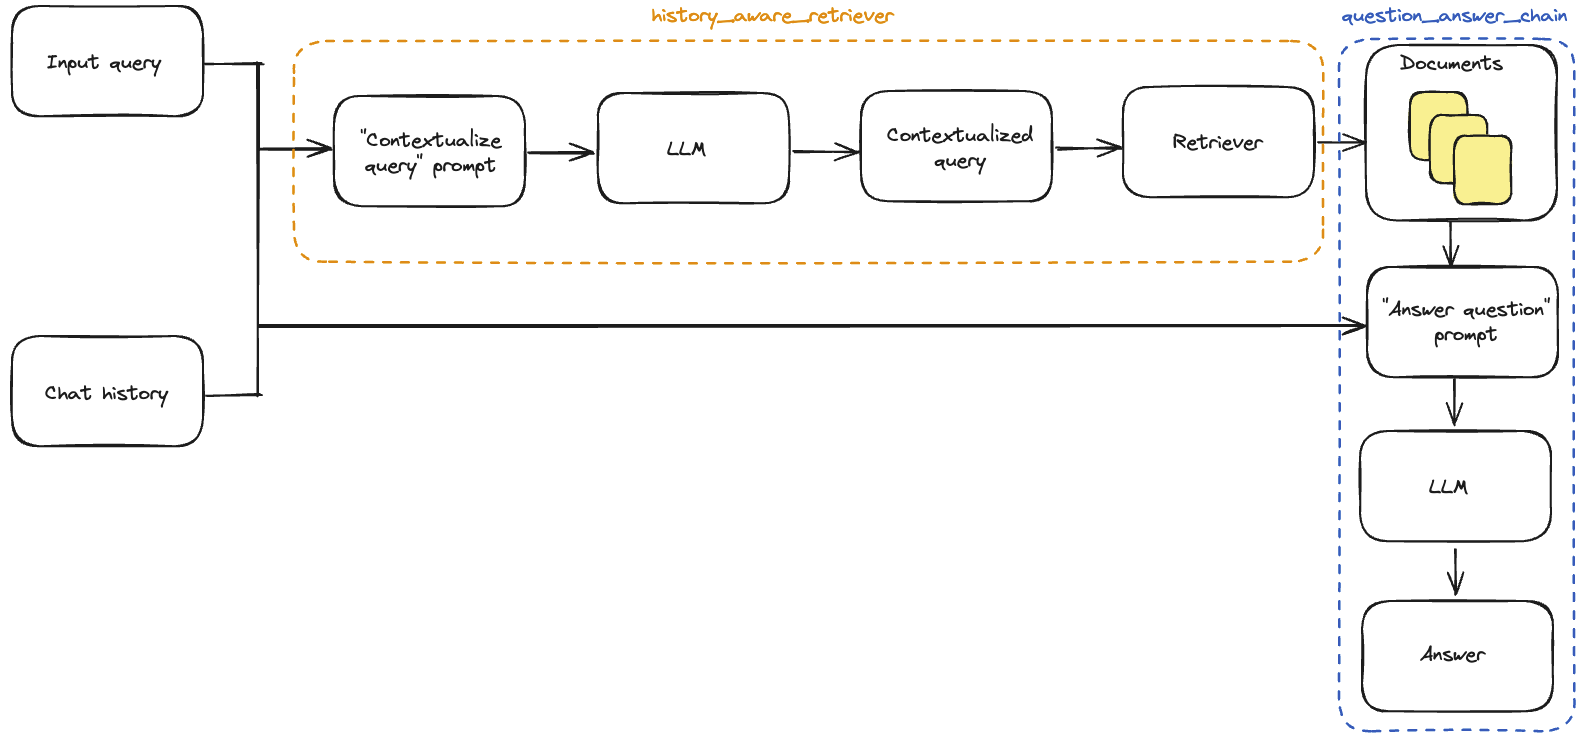

In [327]:
response.keys()

dict_keys(['input', 'chat_history', 'context', 'answer'])

In [329]:
response['input']

'explain ridge regression in context of high dimensional problems'

In [333]:
response['chat_history']

[]

In [335]:
response['context']

[Document(id='07cf95bb-ef63-4ba4-9514-02161fe5cccb', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 760}, page_content='over the 100 simulation runs. The p= 1000 case is designed to mimic the\nkind of data that we might see in a high-dimensional genomic o r proteomic\ndataset, for example.\nWe ﬁt a ridge regression to the data, with three diﬀerent valu es for the\nregularization parameter λ: 0.001, 100, and 1000. When λ= 0.001, this\nis nearly the same as least squares regression, with a little regularization\njust to ensure that the problem is non-singular when p > N. Figure 18.1'),
 Document(id='985cd759-7665-47ad-8cd5-45255d6c4080', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 1150}, page_content='just to ensure that the problem is non-singular when p > N. Figure 18.

In [337]:
response['answer']

"In the context of high-dimensional problems, such as genomic or proteomic datasets with thousands of features, Ridge Regression is a regularization technique used to prevent overfitting and improve model generalizability.\n\nRidge Regression adds a penalty term to the least squares loss function, which is proportional to the magnitude of the regression coefficients. This penalty term, controlled by the regularization parameter λ, encourages the model to produce smaller coefficients for all features, thereby reducing the impact of noise and irrelevant variables on the model's performance.\n\nBy doing so, Ridge Regression:\n\n1. Reduces overfitting: By shrinking the coefficients towards zero, Ridge Regression prevents the model from memorizing the training data and generalizes better to new, unseen data.\n2. Improves interpretability: The regularization parameter λ provides a more interpretable measure of the model's complexity than the number of features used.\n3. Handles high-dimensio

In [339]:
sample_query

'for high-dimensional problems, with regards to p and N, in what cases can ridge regression exploit the correlation in the features of the dataset?'

In [341]:
response2 = conversational_rag_chain.invoke(
    input={
        'input': f'elaborate on this and also explain {sample_query}'
    },
    config={
        'configurable':{'session_id':'1'}
    }
)

In [347]:
response2['input']

'elaborate on this and also explain for high-dimensional problems, with regards to p and N, in what cases can ridge regression exploit the correlation in the features of the dataset?'

In [349]:
response2['chat_history']

[HumanMessage(content='explain ridge regression in context of high dimensional problems'),
 AIMessage(content="In the context of high-dimensional problems, such as genomic or proteomic datasets with thousands of features, Ridge Regression is a regularization technique used to prevent overfitting and improve model generalizability.\n\nRidge Regression adds a penalty term to the least squares loss function, which is proportional to the magnitude of the regression coefficients. This penalty term, controlled by the regularization parameter λ, encourages the model to produce smaller coefficients for all features, thereby reducing the impact of noise and irrelevant variables on the model's performance.\n\nBy doing so, Ridge Regression:\n\n1. Reduces overfitting: By shrinking the coefficients towards zero, Ridge Regression prevents the model from memorizing the training data and generalizes better to new, unseen data.\n2. Improves interpretability: The regularization parameter λ provides a mo

In [351]:
response2['context']

[Document(id='0bdfb511-497a-44a7-a808-15f7dc4cb02e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'),
 Document(id='07cf95bb-ef63-4ba4-9514-02161fe5cccb', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 760}, page_content='over the 100 simulation runs. The p= 1000 case is des

In [353]:
response2['answer']

"**Ridge Regression in High-Dimensional Problems**\n\nIn high-dimensional problems, where the number of features (p) exceeds the number of observations (N), traditional least squares regression can struggle to converge. This is because the model needs to estimate a large number of coefficients, which can lead to overfitting and poor generalization performance.\n\nRidge Regression can be particularly effective in these scenarios by:\n\n1. **Reducing overfitting**: By shrinking the coefficients towards zero, Ridge Regression prevents the model from memorizing the training data and generalizes better to new, unseen data.\n2. **Improving interpretability**: The regularization parameter λ provides a more interpretable measure of the model's complexity than the number of features used.\n\nHowever, for high-dimensional problems, Ridge Regression can only exploit the correlation in the features when:\n\n* **p < N**: When the number of features is less than or equal to the number of observation

Note: this system is not stateful yet

* Statefulness:
Stateful typically refers to the system’s ability to persist data across sessions or restarts. In your current implementation, history is only preserved for the duration of the session (i.e., while the program is running). If you stop the program and restart it, the conversation history will be reset because the store is not persisted.
* What is Missing:
The missing part here is likely persistent memory, which would allow the system to retain conversation history even after a session or the program ends. This could be implemented using:
    * A database to store conversation history (like SQLite, MongoDB, etc.).
External memory integration, like LangChain’s memory modules that store history in more scalable, persistent ways.
    * A file-based storage system (e.g., writing the history to a file that can be loaded again when needed).

In [386]:
sample_query

'for high-dimensional problems, with regards to p and N, in what cases can ridge regression exploit the correlation in the features of the dataset?'

In [384]:
for d in response2["context"]:
    print(f"page {d.metadata['page']} of {d.metadata['source'].split('/')[-1]}")
    print(f"content: {d.page_content}")
    print()

page 2 of chap18.pdf
content: using the optimal ridge parameter in each of the three cases, the median
value of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values
exceeding 2 was equal to 9.8, 1.2 and 0.0.
Ridge regression with λ= 0.001 successfully exploits the correlation in
the features when p<N, but cannot do so when p≫N. In the latter case
there is not enough information in the relatively small numb er of samples
to eﬃciently estimate the high-dimensional covariance mat rix. In that case,

page 1 of chap18.pdf
content: over the 100 simulation runs. The p= 1000 case is designed to mimic the
kind of data that we might see in a high-dimensional genomic o r proteomic
dataset, for example.
We ﬁt a ridge regression to the data, with three diﬀerent valu es for the
regularization parameter λ: 0.001, 100, and 1000. When λ= 0.001, this
is nearly the same as least squares regression, with a little regularization
just to ensure that the problem is non-singular when p > N. Figure 18

In [380]:
p="jnvondsfvnidofs"
p.split("--")[0]

'jnvondsfvnidofs'

In [394]:
conversational_rag_chain

RunnableWithMessageHistory(bound=RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  chat_history: RunnableBinding(bound=RunnableLambda(_enter_history), config={'run_name': 'load_history'})
}), config={'run_name': 'insert_history'})
| RunnableBinding(bound=RunnableLambda(_call_runnable_sync), config={'run_name': 'check_sync_or_async'}), config={'run_name': 'RunnableWithMessageHistory'}), get_session_history=<function get_session_history at 0x3f76a9430>, input_messages_key='input', output_messages_key='answer', history_messages_key='chat_history', history_factory_config=[ConfigurableFieldSpec(id='session_id', annotation=<class 'str'>, name='Session ID', description='Unique identifier for a session.', default='', is_shared=True, dependencies=None)])

# python script setup

In [ ]:
print()

import os
import glob
import time
import argparse
from tqdm import tqdm
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import ChatOllama
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.chat_message_histories import ChatMessageHistory
# from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
import warnings
# from urllib3.exceptions import NotOpenSSLWarning
# Suppress all warnings
warnings.filterwarnings("ignore")
# Suppress NotOpenSSLWarning from urllib3
warnings.filterwarnings("ignore", module='urllib3')





def load_pdfs(file_paths):
    """
    file_paths must end with .pdf
    PyPDFLoader auto splits the pdf into pages, each page is 1 Document object split by page number

    returns a dict of key: file_path and value: list of document objects
    """
    documents_dict = {}   
    for f in tqdm(file_paths):
        loader = PyPDFLoader(file_path = f)
        documents = loader.load()
        documents_dict[f] = documents
    return documents_dict

def chunk_list_of_documents(documents):
    """
    input a list of documents as Document objects

    output a list of chunks as Document objects
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 500,
        chunk_overlap = 100, # using 20% is a good start
        length_function=len,
        is_separator_regex=False,
        add_start_index=True
    )

    chunks = text_splitter.split_documents(documents)    
    return chunks

def get_session_history(session_id: str):
    if session_id not in chat_history_store:
        chat_history_store[session_id] = ChatMessageHistory()
    return chat_history_store[session_id]


def create_huggingface_retriever(folder_path,embedding_model_name):
    files_paths = glob.glob(f"{folder_path}/*.pdf")
    print()
    print()

    # load documents from file paths
    print("loading pdfs...")
    documents_dict = load_pdfs(file_paths=files_paths)

    # chunk documents
    print()
    print("chunking documents...")
    all_chunks = []
    for key in tqdm(documents_dict.keys()):
        documents = documents_dict[key]
        chunks = chunk_list_of_documents(documents=documents)
        all_chunks.extend(chunks)
    print(f"number of chunks: {len(all_chunks)}")

    # setup embedding model
    model_kwargs = {'device': 'cpu'}
    encode_kwargs = {'normalize_embeddings': False}
    hf_embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )

    # setup vectordb, using HF embedding model
    start_time=time.time()
    print()
    print("start process of embedding chunks into vector database...")
    vectorstore_hf = InMemoryVectorStore.from_documents(
        documents=all_chunks,
        embedding=hf_embedding_model
    )
    print("all chunks embedded into vector database!",f"time taken: {round(time.time()-start_time,2)}s")

    # setup retrieval and test with a query and gt_context
    retriever_hf = vectorstore_hf.as_retriever(
        search_type='similarity',
        search_kwargs = {'k':5}
    )
    print("retriever created!")

    return retriever_hf


def create_conversational_rag_chain(retriever_hf,llm_model_name):

    print("creating custom RAG Chat LLM...")
    # setup llm chat model using ollama
    llm_model = ChatOllama(
        model=llm_model_name,
        temperature=0 # increase temp for more creative answers
    ) 

    # setup system contextualise input prompt
    system_contextualise_input_prompt = (
        "Given a chat history and the latest user question "
        "which might reference context in the chat history, "
        "formulate a standalone question which can be understood "
        "without the chat history. Do NOT answer the question, "
        "just reformulate it if needed and otherwise return it as is."
    )
    system_input_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_contextualise_input_prompt),
            MessagesPlaceholder("chat_history"),
            ("human", "{input}"),
        ]
    )

    # instantiate the history-aware retriever:
    history_aware_retriever = create_history_aware_retriever(
        llm=llm_model,
        retriever=retriever_hf,
        prompt=system_input_prompt
    )

    # setup system RAG QnA prompt
    system_rag_qna_prompt = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        "{context}"
    )
    system_rag_prompt = ChatPromptTemplate.from_messages(
        [
            ('system',system_rag_qna_prompt),
            MessagesPlaceholder("chat_history"),
            ('human',"{input}"),
        ]
    )

    # instantiate qna_chain
    qna_chain = create_stuff_documents_chain(llm=llm_model,prompt=system_rag_prompt)

    # instantiate rag_chain
    rag_chain = create_retrieval_chain(retriever=history_aware_retriever,combine_docs_chain=qna_chain)

    # create overall conversational RAG Chain
    conversational_rag_chain = RunnableWithMessageHistory(
        runnable=rag_chain,
        get_session_history=get_session_history,
        input_messages_key="input",
        history_messages_key="chat_history",
        output_messages_key="answer"
    )

    print("RAG Chat LLM creation complete!")
    return conversational_rag_chain


def main(folder_path,embedding_model_name,llm_model_name):
    if embedding_model_name is None:
        embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
    if llm_model_name is None:
        llm_model_name = 'llama3.1'

    # Create the Hugging Face retriever
    retriever_hf = create_huggingface_retriever(folder_path=folder_path,embedding_model_name=embedding_model_name)
    # Create the conversational RAG chain
    conversational_rag_chain = create_conversational_rag_chain(retriever_hf=retriever_hf,llm_model_name=llm_model_name)

    # Initialize the chat loop
    print()
    print()
    print("You can now start chatting with the LLM.")
    print("Add '--show references' to the end of the input to view the retrieved context chunks referenced by the LLM for answer generation.")
    print("Type 'end session' to stop the conversation.")

    session_id = '1'  # Can be replaced with a unique session ID if needed

    while True:
        print()
        print()
        # Get user input
        full_user_input = input("User input: ")

        # Only take the first part of the user input if --show references is used
        user_input = full_user_input.split("--")[0]

        # End session if user types 'end session'
        if user_input.lower() == "end session":
            print("Ending session. Goodbye!")
            break
        
        # Invoke the conversational RAG chain with the user input
        start_time = time.time()
        response = conversational_rag_chain.invoke(
            input={'input': user_input},
            config={'configurable': {'session_id': session_id}}
        )
        
        # Get the model's answer and print it
        answer = response['answer']
        print(f"LLM Assistant: {answer}")
        print(f"time taken: {round(time.time()-start_time,2)}s")

        # Show the references if user requests
        if full_user_input.split("--")[-1]=="show references":
            print()
            print("References:")
            for i,d in enumerate(response["context"]):
                print(f"{i+1} From: page {d.metadata['page']} of {d.metadata['source'].split('/')[-1]}")
                print(f"Content: {d.page_content}")
                print()



if __name__=="__main__":
    print()

    parser = argparse.ArgumentParser(description="Directly use Conversational RAG with custom PDF documents in terminal.")
    # Add arguments
    parser.add_argument("--folder_path", type=str, help="input absolute folder path to folder of pdfs", required=True)
    parser.add_argument("--embedding_model_name", type=str, help="pass the huggingface embedding model name of your choice", required=False)
    parser.add_argument("--llm_model_name", type=str, help="pass the ollama llm model name of your choice", required=False)

    # Parse the arguments
    args = parser.parse_args()

    # create global variable for chat_history_store
    chat_history_store = {}

    # Run the main chat function 
    main(
        folder_path=args.folder_path,
        embedding_model_name=args.embedding_model_name,
        llm_model_name=args.llm_model_name
    )

In [399]:
import ollama

response = ollama.chat(model='llama3.1', messages=[
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])
print(response['message']['content'])

The sky appears blue to us because of a phenomenon called Rayleigh scattering. Here's why:

1. **Sunlight**: The sun emits white light, which contains all the colors of the visible spectrum (red, orange, yellow, green, blue, indigo, and violet).
2. **Atmosphere**: When this sunlight enters Earth's atmosphere, it encounters tiny molecules of gases such as nitrogen (N2) and oxygen (O2). These molecules are much smaller than the wavelength of light.
3. **Scattering**: The shorter wavelengths (like blue and violet) are scattered in all directions by these gas molecules. This is known as Rayleigh scattering. The longer wavelengths (like red and orange) pass through the atmosphere largely unchanged.
4. **Visibility**: Since our eyes are more sensitive to blue light than other colors, we see the scattered blue light from all directions and perceive the sky as blue.

It's worth noting that:

* **Time of day**: During sunrise and sunset, the sky can take on hues of red and orange because the su

In [401]:
# import ollama

response = ollama.chat(model='llama3.1', messages=[
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])
print(response['message']['content'])

The sky appears blue to us because of a phenomenon called scattering, which involves the interaction between sunlight and tiny molecules in the atmosphere.

Here's a simplified explanation:

1. **Sunlight enters Earth's atmosphere**: When the sun shines, it sends out all kinds of electromagnetic radiation, including visible light.
2. **Molecules scatter shorter wavelengths**: As sunlight travels through the atmosphere, it encounters tiny molecules like nitrogen (N2) and oxygen (O2). These molecules are much smaller than the wavelength of light and have a similar size to the wavelength of blue and violet light. When this happens, they scatter these shorter-wavelength lights in all directions.
3. **Blue light is scattered more**: Of all the colors in the visible spectrum, blue light has the shortest wavelength (around 450-495 nanometers). This means it gets scattered by the atmosphere's molecules more frequently than other colors, especially when compared to longer wavelengths like red a

In [403]:
# import ollama

stream = ollama.chat(
    model='llama3.1',
    messages=[{'role': 'user', 'content': 'Why is the sky blue?'}],
    stream=True,
)

for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)

The sky appears blue to us during the daytime because of a phenomenon called scattering. Scattering occurs when sunlight interacts with tiny molecules of gases in the Earth's atmosphere, such as nitrogen (N2) and oxygen (O2).

Here's a simplified explanation:

1. **Sunlight is made up of all colors**: When sunlight enters Earth's atmosphere, it contains all the colors of the visible spectrum, including red, orange, yellow, green, blue, indigo, and violet.

2. **Scattering favored by shorter wavelengths**: The smaller molecules in the air scatter light more effectively when the light waves are shorter (i.e., have higher frequencies). Blue light has a relatively short wavelength compared to other colors of the visible spectrum.

3. **Blue light is scattered more than others**: As sunlight travels through the atmosphere, the blue part of the spectrum gets scattered in all directions by the nitrogen and oxygen molecules. This scattering favors the shorter wavelengths of light, making it ap

In [419]:
# import ollama

stream = ollama.chat(
    model='llama3.1',
    messages=[{'role': 'user', 'content': 'Why is the sky blue?'}],
    stream=True,
)

for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)

The sky appears blue to us because of a phenomenon called scattering, which occurs when sunlight interacts with the tiny molecules of gases in the Earth's atmosphere. Here's a simplified explanation:

1. **Sunlight enters the atmosphere**: When the sun shines, it sends out all its colors, including red, orange, yellow, green, and blue.
2. **Scattering happens**: As these colors travel through the atmosphere, they encounter tiny molecules of gases such as nitrogen (N2) and oxygen (O2). These molecules are much smaller than the wavelength of light, so when they collide with each other, they scatter the light in all directions.
3. **Blue light is scattered more**: The shorter wavelengths, like blue and violet, are scattered more easily than the longer wavelengths, like red and orange. This is because the smaller molecules have a greater effect on the shorter wavelengths.
4. **Our eyes see the scattered blue light**: When we look up at the sky, our eyes see the scattered blue light that ha

In [411]:
u = "sdvdf fvdfvdf vddfv --show references"
v = "sdvdf fvdfvdf vddfv"

In [417]:
len(u.split("--"))

2

In [415]:
len(v.split("--"))

1

In [435]:
# mtd 1 for instantiating chat ollama model - newer version

from langchain_ollama import ChatOllama

# setup llm chat model using ollama
llm_model1 = ChatOllama(
    model="llama3.1",
    temperature=0 # increase temp for more creative answers
) 

In [437]:
llm_model.invoke("whats the weather today?")

AIMessage(content="I'm a large language model, I don't have real-time access to current weather conditions. However, I can suggest some ways for you to find out the weather today:\n\n1. **Check online weather websites**: You can visit websites like AccuWeather, Weather.com, or the National Weather Service (NWS) for up-to-date weather information.\n2. **Use a voice assistant**: If you have a smart speaker or virtual assistant like Siri, Google Assistant, or Alexa, you can ask them to tell you the current weather.\n3. **Check your phone's weather app**: Most smartphones come with a built-in weather app that provides current and forecasted weather conditions.\n4. **Look out the window!**: If you're near a window, take a glance outside to see what the weather is like.\n\nIf you'd like, I can also suggest some general weather-related topics or questions we could chat about instead?", response_metadata={'model': 'llama3.1', 'created_at': '2024-09-18T02:10:43.671768Z', 'message': {'role': 'as

In [451]:
# mtd 2 for instantiating chat ollama model

from langchain_community.chat_models.ollama import ChatOllama

llm_model2 = ChatOllama(
    model='llama3.1',
    temperature=0,
    disable_streaming=False
)

In [461]:
# response = await(llm_model.ainvoke("whats the weather today?"))
response = await(llm_model.abatch("whats the weather today?"))

In [465]:
# response = await(llm_model.ainvoke("whats the weather today?"))
response = llm_model.astream("whats the weather today?")

In [467]:
response

<async_generator object BaseChatModel.astream at 0x3f769fca0>

In [459]:
response

AIMessage(content="I'm a large language model, I don't have real-time access to current weather conditions. However, I can suggest some ways for you to find out the weather today:\n\n1. **Check online weather websites**: You can visit websites like AccuWeather, Weather.com, or the National Weather Service (NWS) for up-to-date weather information.\n2. **Use a voice assistant**: If you have a smart speaker or virtual assistant like Siri, Google Assistant, or Alexa, you can ask them to tell you the current weather.\n3. **Check your phone's weather app**: Most smartphones come with a built-in weather app that provides current and forecasted weather conditions.\n4. **Look out the window!**: If you're near a window, take a glance outside to see what the weather is like.\n\nIf you'd like, I can also suggest some general weather-related topics or questions we could chat about instead?", response_metadata={'model': 'llama3.1', 'created_at': '2024-09-18T02:46:59.309123Z', 'message': {'role': 'as

In [469]:
conversational_rag_chain

RunnableWithMessageHistory(bound=RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  chat_history: RunnableBinding(bound=RunnableLambda(_enter_history), config={'run_name': 'load_history'})
}), config={'run_name': 'insert_history'})
| RunnableBinding(bound=RunnableLambda(_call_runnable_sync), config={'run_name': 'check_sync_or_async'}), config={'run_name': 'RunnableWithMessageHistory'}), get_session_history=<function get_session_history at 0x3f76a9430>, input_messages_key='input', output_messages_key='answer', history_messages_key='chat_history', history_factory_config=[ConfigurableFieldSpec(id='session_id', annotation=<class 'str'>, name='Session ID', description='Unique identifier for a session.', default='', is_shared=True, dependencies=None)])

In [471]:
user_input = "explain high dimensional problems in statistical learning?"

In [477]:
# Use streaming to get the response incrementally
response = conversational_rag_chain.invoke(
    input={'input': user_input},
    config={'stream': True,'configurable':{'session_id':'1'}}  # If config supports stream, add this
)

# Stream the response
for token in response:
    print(token, end="", flush=True)

inputchat_historycontextanswer

In [479]:
# response = await(llm_model.ainvoke("whats the weather today?"))
response = llm_model.ainvoke("whats the weather today?")

In [485]:
import asyncio
asyncio.run(response)

RuntimeError: asyncio.run() cannot be called from a running event loop

# try ollama python package directly with input

In [492]:
sample_query

'for high-dimensional problems, with regards to p and N, in what cases can ridge regression exploit the correlation in the features of the dataset?'

In [494]:
sample_gt_context

Document(metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,')

In [500]:
chat_history_store = {}

In [502]:
history_aware_retriever.invoke(
    input={
        'input':sample_query,
        'chat_history':chat_history_store    
    }
)

[Document(id='0bdfb511-497a-44a7-a808-15f7dc4cb02e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'),
 Document(id='07cf95bb-ef63-4ba4-9514-02161fe5cccb', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 760}, page_content='over the 100 simulation runs. The p= 1000 case is des

In [487]:
import ollama

stream = ollama.chat(
    model='llama3.1',
    messages=[{'role': 'user', 'content': 'Why is the sky blue?'}],
    stream=True,
)

for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)

The sky appears blue to us because of a phenomenon called scattering, which occurs when sunlight interacts with the tiny molecules of gases in the atmosphere. Here's a simplified explanation:

1. **Sunlight**: The sun emits a broad spectrum of electromagnetic radiation, including visible light, ultraviolet (UV) rays, and other forms of energy.
2. **Atmospheric particles**: The Earth's atmosphere is composed of various gases, such as nitrogen (N2), oxygen (O2), carbon dioxide (CO2), and others. These gases contain tiny molecules that are scattered throughout the air.
3. **Scattering**: When sunlight enters the atmosphere, it encounters these tiny molecules. The shorter wavelengths of light, like blue and violet, are more easily scattered by these molecules than longer wavelengths, such as red and orange.
4. **Rayleigh scattering**: This is the specific type of scattering that occurs when light interacts with small particles (like the atmospheric gases). It's named after Lord Rayleigh, w

1. setup history aware retriever
2. pass context to chat prompt
3. use python ollama to generate response and append to chat history

In [527]:
chat_history_store

{}

In [508]:
def create_huggingface_retriever(folder_path,embedding_model_name):
    files_paths = glob.glob(f"{folder_path}/*.pdf")
    print()
    print()

    # load documents from file paths
    print("loading pdfs...")
    documents_dict = load_pdfs(file_paths=files_paths)

    # chunk documents
    print()
    print("chunking documents...")
    all_chunks = []
    for key in tqdm(documents_dict.keys()):
        documents = documents_dict[key]
        chunks = chunk_list_of_documents(documents=documents)
        all_chunks.extend(chunks)
    print(f"number of chunks: {len(all_chunks)}")

    # setup embedding model
    model_kwargs = {'device': 'cpu'}
    encode_kwargs = {'normalize_embeddings': False}
    hf_embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )

    # setup vectordb, using HF embedding model
    start_time=time.time()
    print()
    print("start process of embedding chunks into vector database...")
    vectorstore_hf = InMemoryVectorStore.from_documents(
        documents=all_chunks,
        embedding=hf_embedding_model
    )
    print("all chunks embedded into vector database!",f"time taken: {round(time.time()-start_time,2)}s")

    # setup retrieval and test with a query and gt_context
    retriever_hf = vectorstore_hf.as_retriever(
        search_type='similarity',
        search_kwargs = {'k':5}
    )
    print("retriever created!")

    return retriever_hf

In [510]:
# setup history_aware_retriever

folder_path = "/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book"
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
retriever_hf = create_huggingface_retriever(folder_path,embedding_model_name)



loading pdfs...


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]



chunking documents...


100%|██████████| 3/3 [00:00<00:00, 443.33it/s]


number of chunks: 528

start process of embedding chunks into vector database...
all chunks embedded into vector database! time taken: 26.88s
retriever created!


In [523]:
from langchain.chains import create_history_aware_retriever

def instantiate_history_aware_retriever(llm_model_name):
    
    # setup llm model for refining the user input with conversation context
    prompt_refiner_llm = ChatOllama(
        model=llm_model_name,
        temperature=0 # increase temp for more creative answers
    ) 
    
    # setup system contextualise input prompt
    system_contextualise_input_prompt = (
        "Given a chat history and the latest user question "
        "which might reference context in the chat history, "
        "formulate a standalone question which can be understood "
        "without the chat history. Do NOT answer the question, "
        "just reformulate it if needed and otherwise return it as is."
    )
    system_input_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_contextualise_input_prompt),
            MessagesPlaceholder("chat_history"),
            ("human", "{input}"),
        ]
    )

    # instantiate the history-aware retriever:
    history_aware_retriever = create_history_aware_retriever(
        llm=prompt_refiner_llm,
        retriever=retriever_hf,
        prompt=system_input_prompt
    )

    return history_aware_retriever

In [545]:
history_aware_retriever = instantiate_history_aware_retriever(llm_model_name="llama3.1")
history_aware_retriever

RunnableBinding(bound=RunnableBranch(branches=[(RunnableLambda(lambda x: not x.get('chat_history', False)), RunnableLambda(lambda x: x['input'])
| VectorStoreRetriever(tags=['InMemoryVectorStore', 'HuggingFaceEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x3f75caee0>, search_kwargs={'k': 5}))], default=ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='Given a chat history and the latest user question which might reference context in the chat history, formulate a standalone question which can be understood without the chat hi

In [563]:
from langchain_community.chat_message_histories import ChatMessageHistory

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in chat_history_store:
        chat_history_store[session_id] = ChatMessageHistory()
    return chat_history_store[session_id]

In [565]:
session_id = "1"
chat_history1 = get_session_history(session_id)
chat_history1

InMemoryChatMessageHistory(messages=[])

In [567]:
chat_history1

InMemoryChatMessageHistory(messages=[])

In [569]:
history_aware_retriever.invoke(
    input = {
        'input':sample_query,
        'chat_history':chat_history1
    }
)

ValueError: variable chat_history should be a list of base messages, got  of type <class 'langchain_core.chat_history.InMemoryChatMessageHistory'>

# without using alot of the langchain stuff

* without using history_aware_retriever

In [712]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

In [714]:
# 1. setup conversation history

chat_history_store = {}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

In [777]:
session_id = "2"
current_chat_history = get_session_history(session_id)
current_chat_history

InMemoryChatMessageHistory(messages=[])

In [779]:
# add some messages

current_chat_history.add_user_message("hi do you know what pythagoras theorem is? just say yes or no")
current_chat_history.add_ai_message("Yes. What would you like to know about it?")
current_chat_history

InMemoryChatMessageHistory(messages=[HumanMessage(content='hi do you know what pythagoras theorem is? just say yes or no'), AIMessage(content='Yes. What would you like to know about it?')])

In [787]:
get_session_history("2")

InMemoryChatMessageHistory(messages=[HumanMessage(content='hi do you know what pythagoras theorem is? just say yes or no'), AIMessage(content='Yes. What would you like to know about it?')])

history_aware_retriever

* Create a chain that takes conversation history and returns documents.
* If there is no chat_history, then the input is just passed directly to the retriever. If there is chat_history, then the prompt and LLM will be used to generate a search query. That search query is then passed to the retriever.

In [722]:
# setup llm model for refining the user input with conversation context

from langchain_ollama import ChatOllama

query_refiner_llm_model_name = "llama3.1"
query_refiner_llm = ChatOllama(
    model=query_refiner_llm_model_name,
    temperature=0 # increase temp for more creative answers
) 

In [724]:
# test
query_refiner_llm.invoke("hi")

AIMessage(content="How's it going? Is there something I can help you with or would you like to chat?", response_metadata={'model': 'llama3.1', 'created_at': '2024-09-18T05:46:38.621339Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 1068434333, 'load_duration': 28997833, 'prompt_eval_count': 11, 'prompt_eval_duration': 310055000, 'eval_count': 21, 'eval_duration': 728042000}, id='run-917dec4c-7b87-4d65-a426-54d0ae073f47-0', usage_metadata={'input_tokens': 11, 'output_tokens': 21, 'total_tokens': 32})

In [748]:
current_chat_history

InMemoryChatMessageHistory(messages=[HumanMessage(content='hi do you know what pythagoras theorem is? just say yes or no'), AIMessage(content='Yes. What would you like to know about it?')])

In [758]:
def refine_input_query_with_chat_history_context(session_id, input_query, query_refiner_llm):
    """
    session_id is tyope str - the sessions_id of the chat history
    input_query is type str - input in the terminal by the user
    query_refiner_llm is a base chat LLM used to refine the input query with context of the chat history
    """
    chat_history = get_session_history(session_id)

    # Setup system contextualise input prompt
    system_contextualize_input_prompt = (
        "Given a chat history and the latest user question "
        "which might reference context in the chat history, "
        "formulate a standalone question which can be understood "
        "without the chat history. Do NOT answer the question, "
        "just reformulate it if needed and otherwise return it as is."
    )
    
    # Prepare the chat prompt template with the chat history
    system_input_prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system", system_contextualize_input_prompt),
            MessagesPlaceholder(variable_name="chat_history"),  # For history
            ("human", "{input}"),  # User's latest input query
        ]
    )

    # Format the chat history as a list of dictionaries (required for MessagesPlaceholder)
    formatted_chat_history = []
    for message in chat_history.messages:
        if isinstance(message, HumanMessage):
            formatted_chat_history.append({"role": "human", "content": message.content})
        elif isinstance(message, AIMessage):
            formatted_chat_history.append({"role": "ai", "content": message.content})

    # Invoke the template with chat history and input query
    system_input_prompt_value = system_input_prompt_template.invoke(
        {
            'chat_history': formatted_chat_history,  # Pass the formatted history
            'input': input_query  # User's current query
        }
    )

    print("chat history:")
    print(system_input_prompt_value.messages)
    
    # Use the query_refiner_llm to get the refined_query
    refined_query = query_refiner_llm.invoke(
        input = system_input_prompt_value.messages
    )
    
    return refined_query

In [760]:
refined_query =  refine_input_query_with_chat_history_context(
    session_id='2',
    input_query="okay explain it.",
    query_refiner_llm=query_refiner_llm
)

chat history:
[SystemMessage(content='Given a chat history and the latest user question which might reference context in the chat history, formulate a standalone question which can be understood without the chat history. Do NOT answer the question, just reformulate it if needed and otherwise return it as is.'), HumanMessage(content='hi do you know what pythagoras theorem is? just say yes or no'), AIMessage(content='Yes. What would you like to know about it?'), HumanMessage(content='okay explain it.')]


In [756]:
system_input_prompt_value.messages

[SystemMessage(content='Given a chat history and the latest user question which might reference context in the chat history, formulate a standalone question which can be understood without the chat history. Do NOT answer the question, just reformulate it if needed and otherwise return it as is.'),
 HumanMessage(content='hi do you know what pythagoras theorem is? just say yes or no'),
 AIMessage(content='Yes. What would you like to know about it?'),
 HumanMessage(content='okay explain it.')]

In [762]:
refined_query.content

"The Pythagorean Theorem states that in a right-angled triangle, the square of the length of the hypotenuse (the side opposite the right angle) is equal to the sum of the squares of the lengths of the other two sides.\n\nMathematically, this can be expressed as:\n\na² + b² = c²\n\nwhere 'a' and 'b' are the lengths of the two shorter sides, and 'c' is the length of the hypotenuse."

issue here is that the refined_query_llm is not returning the refined query but directly answering the question

## others 

In [590]:
current_chat_history.add_user_message("hi can you explain pythagoras theorem to me?")

In [592]:
current_chat_history

InMemoryChatMessageHistory(messages=[HumanMessage(content='hi can you explain pythagoras theorem to me?')])

In [594]:
current_chat_history.add_ai_message("i cant find information on that in the vector db")

In [598]:
current_chat_history.messages

[HumanMessage(content='hi can you explain pythagoras theorem to me?'),
 AIMessage(content='i cant find information on that in the vector db')]

In [688]:
from langchain.schema import AIMessage, HumanMessage

def refine_query_with_context(input_query, session_id, query_refiner_llm):
    """
    Refines the input query by considering the chat history.
    """
    # Get the chat history for the session (assume you have a function to fetch it)
    chat_history = get_session_history(session_id)

    # Setup system contextualize input prompt
    system_contextualize_input_prompt = (
        "Given a chat history and the latest user question "
        "which might reference context in the chat history, "
        "formulate a standalone question which can be understood "
        "without the chat history. Do NOT answer the question, "
        "just reformulate it if needed and otherwise return it as is."
    )

    # Prepare the chat prompt template with the chat history
    system_input_prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system", system_contextualize_input_prompt),
            MessagesPlaceholder(variable_name="chat_history"),  # For history
            ("human", "{input}"),  # User's latest input
        ]
    )

    # Format the chat history as a list of dictionaries (required for MessagesPlaceholder)
    formatted_history = []
    for message in chat_history.messages:
        if isinstance(message, HumanMessage):
            formatted_history.append({"role": "human", "content": message.content})
        elif isinstance(message, AIMessage):
            formatted_history.append({"role": "ai", "content": message.content})

    # Invoke the template with chat history and input query
    refined_query = system_input_prompt_template.invoke(
        {
            'chat_history': formatted_history,  # Pass the formatted history
            'input': input_query  # User's current query
        }
    )

    return refined_query

In [690]:
refined_query = refine_query_with_context(input_query=sample_query,session_id='1',query_refiner_llm=query_refiner_llm)

In [700]:
refined_query.messages

[SystemMessage(content='Given a chat history and the latest user question which might reference context in the chat history, formulate a standalone question which can be understood without the chat history. Do NOT answer the question, just reformulate it if needed and otherwise return it as is.'),
 HumanMessage(content='hi can you explain pythagoras theorem to me?'),
 AIMessage(content='i cant find information on that in the vector db'),
 HumanMessage(content='for high-dimensional problems, with regards to p and N, in what cases can ridge regression exploit the correlation in the features of the dataset?')]

In [704]:
response = query_refiner_llm.invoke(input=refined_query)
response.content

"What is Ridge Regression's ability to exploit feature correlations in high-dimensional spaces when considering p (number of features) and N (sample size)?"

In [ ]:
query_refiner_llm.invoke

In [681]:
system_input_prompt_temmplate = refine_query_with_context(input_query=sample_query,session_id='1',query_refiner_llm=query_refiner_llm)
system_input_prompt_temmplate

ValueError: variable chat_history should be a list of base messages, got Human: hi can you explain pythagoras theorem to me?
AI: i cant find information on that in the vector db of type <class 'langchain_core.chat_history.InMemoryChatMessageHistory'>

build entire pipeline in order without langchain as much as possible

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai.chat_models import ChatOpenAI

    # setup llm model for refining the user input with conversation context
    prompt_refiner_llm = ChatOllama(
        model=llm_model_name,
        temperature=0 # increase temp for more creative answers
    ) 
    

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You're an assistant who's good at {ability}. Respond in 20 words or fewer",
        ),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)
runnable = prompt | model

In [571]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


with_message_history = RunnableWithMessageHistory(
    runnable,
    get_session_history,
    input_messages_key="input",
    history_messages_key="history",
)

NameError: name 'runnable' is not defined

# use history aware retriever -> Python Ollama

In [765]:
print()

import os
import glob
import time
import argparse
from tqdm import tqdm
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import ChatOllama
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.chat_message_histories import ChatMessageHistory
# from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
import warnings
# from urllib3.exceptions import NotOpenSSLWarning
# Suppress all warnings
warnings.filterwarnings("ignore")
# Suppress NotOpenSSLWarning from urllib3
warnings.filterwarnings("ignore", module='urllib3')

def load_pdfs(file_paths):
    """
    file_paths must end with .pdf
    PyPDFLoader auto splits the pdf into pages, each page is 1 Document object split by page number

    returns a dict of key: file_path and value: list of document objects
    """
    documents_dict = {}   
    for f in tqdm(file_paths):
        loader = PyPDFLoader(file_path = f)
        documents = loader.load()
        documents_dict[f] = documents
    return documents_dict

def chunk_list_of_documents(documents):
    """
    input a list of documents as Document objects

    output a list of chunks as Document objects
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 500,
        chunk_overlap = 100, # using 20% is a good start
        length_function=len,
        is_separator_regex=False,
        add_start_index=True
    )

    chunks = text_splitter.split_documents(documents)    
    return chunks

def get_session_history(session_id: str):
    if session_id not in chat_history_store:
        chat_history_store[session_id] = ChatMessageHistory()
    return chat_history_store[session_id]


def create_huggingface_retriever(folder_path,embedding_model_name):
    files_paths = glob.glob(f"{folder_path}/*.pdf")
    print()
    print()

    # load documents from file paths
    print("loading pdfs...")
    documents_dict = load_pdfs(file_paths=files_paths)

    # chunk documents
    print()
    print("chunking documents...")
    all_chunks = []
    for key in tqdm(documents_dict.keys()):
        documents = documents_dict[key]
        chunks = chunk_list_of_documents(documents=documents)
        all_chunks.extend(chunks)
    print(f"number of chunks: {len(all_chunks)}")

    # setup embedding model
    model_kwargs = {'device': 'cpu'}
    encode_kwargs = {'normalize_embeddings': False}
    hf_embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )

    # setup vectordb, using HF embedding model
    start_time=time.time()
    print()
    print("start process of embedding chunks into vector database...")
    vectorstore_hf = InMemoryVectorStore.from_documents(
        documents=all_chunks,
        embedding=hf_embedding_model
    )
    print("all chunks embedded into vector database!",f"time taken: {round(time.time()-start_time,2)}s")

    # setup retrieval and test with a query and gt_context
    retriever_hf = vectorstore_hf.as_retriever(
        search_type='similarity',
        search_kwargs = {'k':5}
    )
    print("retriever created!")

    return retriever_hf


In [769]:
def instantiate_history_aware_retriever(retriever_hf,llm_model_name):

    # setup llm chat model using ollama
    llm_model = ChatOllama(
        model=llm_model_name,
        temperature=0 # increase temp for more creative answers
    ) 

    # setup system contextualise input prompt
    system_contextualise_input_prompt = (
        "Given a chat history and the latest user question "
        "which might reference context in the chat history, "
        "formulate a standalone question which can be understood "
        "without the chat history. Do NOT answer the question, "
        "just reformulate it if needed and otherwise return it as is."
    )
    system_input_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_contextualise_input_prompt),
            MessagesPlaceholder("chat_history"),
            ("human", "{input}"),
        ]
    )

    # instantiate the history-aware retriever:
    history_aware_retriever = create_history_aware_retriever(
        llm=llm_model,
        retriever=retriever_hf,
        prompt=system_input_prompt
    )

    return history_aware_retriever

In [ ]:
retriever_hf = create_huggingface_retriever(folder_path,embedding_model_name)

In [771]:
retriever_hf

VectorStoreRetriever(tags=['InMemoryVectorStore', 'HuggingFaceEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x3f75caee0>, search_kwargs={'k': 5})

In [773]:
history_aware_retriever = instantiate_history_aware_retriever(retriever_hf,"llama3.1")
history_aware_retriever

RunnableBinding(bound=RunnableBranch(branches=[(RunnableLambda(lambda x: not x.get('chat_history', False)), RunnableLambda(lambda x: x['input'])
| VectorStoreRetriever(tags=['InMemoryVectorStore', 'HuggingFaceEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x3f75caee0>, search_kwargs={'k': 5}))], default=ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='Given a chat history and the latest user question which might reference context in the chat history, formulate a standalone question which can be understood without the chat hi

In [791]:
sample_query

'for high-dimensional problems, with regards to p and N, in what cases can ridge regression exploit the correlation in the features of the dataset?'

In [797]:
# create new session history

current_chat_history = get_session_history("3")
current_chat_history

InMemoryChatMessageHistory(messages=[])

In [799]:
# add some messages

current_chat_history.add_user_message("hi do you know about ridge regression being used to exploit the correlation in the features of a dataset?")
current_chat_history.add_ai_message("Yes. What would you like to know about it?")
current_chat_history

InMemoryChatMessageHistory(messages=[HumanMessage(content='hi do you know about ridge regression being used to exploit the correlation in the features of a dataset?'), AIMessage(content='Yes. What would you like to know about it?')])

In [821]:
get_session_history("3")

InMemoryChatMessageHistory(messages=[HumanMessage(content='hi do you know about ridge regression being used to exploit the correlation in the features of a dataset?'), AIMessage(content='Yes. What would you like to know about it?')])

In [823]:
def format_chat_history(chat_history):

    formatted_chat_history = [
        {"role": "human", "content": message.content} if isinstance(message, HumanMessage) else
        {"role": "ai", "content": message.content}
        for message in chat_history.messages
    ]

    return formatted_chat_history

In [825]:
get_session_history("3")

InMemoryChatMessageHistory(messages=[HumanMessage(content='hi do you know about ridge regression being used to exploit the correlation in the features of a dataset?'), AIMessage(content='Yes. What would you like to know about it?')])

In [827]:
formatted_chat_history = format_chat_history(get_session_history("3"))

In [885]:
d = retriever_hf.invoke(
    {
        'input':"explain in which cases can ridge regression do it with regards to p and N in high dimensional problems"
    }
)

AttributeError: 'dict' object has no attribute 'replace'

In [829]:
formatted_chat_history

[{'role': 'human',
  'content': 'hi do you know about ridge regression being used to exploit the correlation in the features of a dataset?'},
 {'role': 'ai', 'content': 'Yes. What would you like to know about it?'}]

In [835]:
retrieved_documents = history_aware_retriever.invoke(
    {
        'chat_history':formatted_chat_history,
        'input':"explain in which cases can ridge regression do it with regards to p and N in high dimensional problems"
    }
)

In [836]:
retrieved_documents

[Document(id='8138d844-2c06-4f04-8c21-011fc2301673', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'),
 Document(id='0717ee14-b5bb-457b-9cde-e239d5292f2e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 368}, page_content='ofp, the number of features. The relative

In [839]:
# sample ollama usage
import ollama

stream = ollama.chat(
    model='llama3.1',
    messages=[{'role': 'user', 'content': 'Why is the sky blue?'}],
    stream=True,
)

for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)

The sky appears blue to us because of a phenomenon called Rayleigh scattering, named after the British physicist Lord Rayleigh who first described it in the late 19th century. This process involves the interaction between sunlight and the tiny molecules of gases in the Earth's atmosphere.

Here's what happens:

1. **Sunlight enters the atmosphere**: When sunlight (which is white) enters the Earth's atmosphere, it encounters a huge number of tiny molecules of gases like nitrogen (N2), oxygen (O2), carbon dioxide (CO2), and others.
2. **Scattering occurs**: These gas molecules are so small that they scatter the light in all directions, but with a preference for shorter (blue) wavelengths over longer (red) wavelengths. This scattering effect is more pronounced for blue light because it has a shorter wavelength than red light.
3. **Blue light reaches our eyes**: As the scattered sunlight travels through the atmosphere, more of the shorter (blue) wavelengths are directed towards the Earth's

In [845]:
formatted_chat_history

[{'role': 'human',
  'content': 'hi do you know about ridge regression being used to exploit the correlation in the features of a dataset?'},
 {'role': 'ai', 'content': 'Yes. What would you like to know about it?'}]

In [847]:
retrieved_documents

[Document(id='8138d844-2c06-4f04-8c21-011fc2301673', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'),
 Document(id='0717ee14-b5bb-457b-9cde-e239d5292f2e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 368}, page_content='ofp, the number of features. The relative

do some prompt engineering for the system prompt to take as input the chat history and the retrieved contexts

In [871]:
# import ollama

def manual_rag_with_ollama(retrieved_documents,formatted_chat_history,input_query, ollama_model_name="llama3.1"):
    """
    Manually performs RAG using retrieved documents from  history-aware-retriever and streams results from the Ollama model.
    
    Args:
        session_id (str): The session ID to fetch chat history.
        input_query (str): The user's input query.
        history_aware_retriever: The retriever to get relevant documents.
        ollama_model_name (str): The name of the Ollama model to use.
    """
    
    # Step 2: Format the retrieved documents as context
    retrieved_contexts = "\n\n".join([doc.page_content for doc in retrieved_documents])
    
    # Step 3: Create a prompt that integrates the retrieved context and input query
    prompt = (
        f"You are an assistant for question-answering tasks. You must reference information from the retrieved_contexts to answer the input_query. "
        f"You must also reference the formatted_chat_history to take into account conversation flow and to ensure that the response is relevant to both the current query and prior conversation. "
        f"Use five sentences maximum and keep the answer concise. "
        "\n\n"
        f"retrieved_contexts: \n{retrieved_contexts}"
        "\n\n"
        f"formatted_chat_history: \n{formatted_chat_history}"
        "\n\n"
        f"input_query: \n{input_query}"
    )

    # Step 4: Pass the prompt to the Ollama LLM and stream the response
    print("Streaming response from Ollama...")

    stream = ollama.chat(
        model=ollama_model_name,
        messages=[{'role': 'user', 'content': prompt}],
        stream=True
    )

    # Stream and display the output from Ollama as it generates
    for chunk in stream:
        print(chunk['message']['content'], end='', flush=True)


In [873]:
retrieved_documents

[Document(id='8138d844-2c06-4f04-8c21-011fc2301673', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'),
 Document(id='0717ee14-b5bb-457b-9cde-e239d5292f2e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 368}, page_content='ofp, the number of features. The relative

In [875]:
formatted_chat_history

[{'role': 'human',
  'content': 'hi do you know about ridge regression being used to exploit the correlation in the features of a dataset?'},
 {'role': 'ai', 'content': 'Yes. What would you like to know about it?'}]

In [877]:
input_query = "explain in which cases can ridge regression do it with regards to p and N in high dimensional problems"

In [879]:
prompt = manual_rag_with_ollama(retrieved_documents,formatted_chat_history,input_query)
# print(prompt)

Streaming response from Ollama...
In high-dimensional problems, Ridge regression can exploit the correlation in features when `p` (number of features) is less than `N` (number of samples). However, when `p > N`, there's not enough information to estimate the high-dimensional covariance matrix efficiently. In this case, more regularization leads to superior prediction performance.

(This answer references the retrieved_contexts and formatted_chat_history: the former provides the relevant information about Ridge regression in high-dimensional problems, while the latter shows that we were previously discussing the same topic.)

In [881]:
prompt = manual_rag_with_ollama(retrieved_documents,formatted_chat_history,input_query)
# print(prompt)

Streaming response from Ollama...
Based on our previous conversation, I recall that ridge regression successfully exploits the correlation in features when p < N, but struggles to do so when p >> N. This is because there's not enough information in the small number of samples to efficiently estimate the high-dimensional covariance matrix.

In the latter case (p > N), more regularization leads to superior prediction performance. So, ridge regression can only exploit correlation effectively in low-dimensional settings where N ≥ p.

Does that clarify things?

In [883]:
get_session_history("3")

InMemoryChatMessageHistory(messages=[HumanMessage(content='hi do you know about ridge regression being used to exploit the correlation in the features of a dataset?'), AIMessage(content='Yes. What would you like to know about it?')])

In [887]:
def format_chat_history(chat_history):
    """
    this function assumes that chat_history is not empty 
    since empty chat_history at the start of the conversation is dealt separately in the main function.
    """

    formatted_chat_history = [
        {"role": "human", "content": message.content} if isinstance(message, HumanMessage) else
        {"role": "ai", "content": message.content}
        for message in chat_history.messages
    ]

    return formatted_chat_history

In [889]:
format_chat_history([])

AttributeError: 'list' object has no attribute 'messages'

In [891]:
retrieved_documents = history_aware_retriever.invoke(
    {
        'chat_history':formatted_chat_history,
        'input':"explain in which cases can ridge regression do it with regards to p and N in high dimensional problems"
    }
)

In [892]:
retrieved_documents

[Document(id='8138d844-2c06-4f04-8c21-011fc2301673', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 2, 'start_index': 397}, page_content='using the optimal ridge parameter in each of the three cases, the median\nvalue of|tj|was 2.0, 0.6 and 0.2, and the average number of |tj|values\nexceeding 2 was equal to 9.8, 1.2 and 0.0.\nRidge regression with λ= 0.001 successfully exploits the correlation in\nthe features when p<N, but cannot do so when p≫N. In the latter case\nthere is not enough information in the relatively small numb er of samples\nto eﬃciently estimate the high-dimensional covariance mat rix. In that case,'),
 Document(id='0717ee14-b5bb-457b-9cde-e239d5292f2e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 368}, page_content='ofp, the number of features. The relative

In [903]:
retrieved_documents = history_aware_retriever.invoke(
    {
        'chat_history':[],
        'input':"explain in which cases can ridge regression do it with regards to p and N in high dimensional problems"
    }
)

In [905]:
retrieved_documents

[Document(id='33217a7b-6db9-4860-8636-442483677a1e', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 760}, page_content='over the 100 simulation runs. The p= 1000 case is designed to mimic the\nkind of data that we might see in a high-dimensional genomic o r proteomic\ndataset, for example.\nWe ﬁt a ridge regression to the data, with three diﬀerent valu es for the\nregularization parameter λ: 0.001, 100, and 1000. When λ= 0.001, this\nis nearly the same as least squares regression, with a little regularization\njust to ensure that the problem is non-singular when p > N. Figure 18.1'),
 Document(id='accd314f-88d7-4864-ad31-8f4ecb55e0a1', metadata={'source': '/Users/I748920/Desktop/llms-learning/pdf-chatbot-app/data/short-elements-of-statistical-learning-book/chap18.pdf', 'page': 1, 'start_index': 1150}, page_content='just to ensure that the problem is non-singular when p > N

In [907]:
c = get_session_history("4")
c

InMemoryChatMessageHistory(messages=[])

In [909]:
f = format_chat_history(c)
f

[]

In [911]:
stream

<generator object Client._stream at 0x400d61740>

In [1]:
import ollama

In [2]:
stream = ollama.chat(
    model="llama3.1",
    messages=[{'role': 'user', 'content': "hows the weather"}],
    stream=True
)

model_answer = ''
# Stream and display the output from Ollama as it generates
for chunk in stream:
    print(chunk['message']['content'], end='', flush=True)
    # model_answer = model_answer.join(chunk)

I'm a large language model, I don't have real-time access to current weather conditions. However, I can suggest some ways for you to find out the current weather:

1. **Check online weather websites**: You can visit websites like AccuWeather, Weather.com, or the National Weather Service (NWS) to get the latest weather updates.
2. **Use a mobile app**: There are many weather apps available on both iOS and Android devices that provide real-time weather information.
3. **Tune into local news**: Watching local news channels or listening to local radio stations can also give you an idea of the current weather conditions.
4. **Ask a voice assistant**: If you have a smart speaker or virtual assistant like Siri, Google Assistant, or Alexa, you can ask them for the current weather.

If you'd like, I can also suggest some general information about different types of weather (e.g., sunny, rainy, cloudy) and how to dress accordingly!

In [8]:
stream = ollama.chat(
    model="llama3.1",
    messages=[{'role': 'user', 'content': "hows the weather"}],
    stream=True
)

model_answer = ''
# Stream and display the output from Ollama as it generates
for chunk in stream:
    print(chunk['message']['content'], end='', flush=True)
    model_answer += chunk['message']['content']  # Append each chunk to the answer

I'm a large language model, I don't have real-time access to your location or current weather conditions. However, I can suggest some ways for you to find out the weather:

1. **Check online weather websites**: You can visit websites like AccuWeather, Weather.com, or the National Weather Service (NWS) for the most up-to-date and accurate weather forecasts.
2. **Use a voice assistant**: If you have a smart speaker or virtual assistant like Siri, Google Assistant, or Alexa, you can simply ask them "What's the weather like today?" or "What's the forecast?"
3. **Check your phone's weather app**: Most smartphones come with a built-in weather app that provides current conditions and forecasts.
4. **Look out the window**: If you're physically near a window, take a glance outside to get an idea of the current weather.

If you want to chat about the weather in general or discuss specific weather-related topics, I'd be happy to engage with you!

In [9]:
# After the loop, `model_answer` will contain the full response
print("\nFull model answer:", model_answer)


Full model answer: I'm a large language model, I don't have real-time access to your location or current weather conditions. However, I can suggest some ways for you to find out the weather:

1. **Check online weather websites**: You can visit websites like AccuWeather, Weather.com, or the National Weather Service (NWS) for the most up-to-date and accurate weather forecasts.
2. **Use a voice assistant**: If you have a smart speaker or virtual assistant like Siri, Google Assistant, or Alexa, you can simply ask them "What's the weather like today?" or "What's the forecast?"
3. **Check your phone's weather app**: Most smartphones come with a built-in weather app that provides current conditions and forecasts.
4. **Look out the window**: If you're physically near a window, take a glance outside to get an idea of the current weather.

If you want to chat about the weather in general or discuss specific weather-related topics, I'd be happy to engage with you!


hi do you know about ridge regression being used to exploit the correlation in the features of a dataset? Only answer yes or no.

AIMessage(content='Yes. What would you like to know about it?'


do you know about high dimensional problems in statistical learning? yes or no.


explain in which cases can ridge regression do it with regards to p and N in high dimensional?  --show references